# Imports

In [49]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

file_name = "rustavi2_parsed_data.parquet"

In [50]:
df = pd.read_parquet(file_name, columns=['url', 'text', 'header'])

In [51]:
df.head()

,url,text,header
0,https://rustavi2.ge/ka/news/19722,ვინ აანაზღაურებს სტიქიის დროს დაზიანებული დაუზ...,"""სახელმწიფო ვერ მოიშორებს პასუხისმგებლობას დაზ..."
1,https://rustavi2.ge/ka/news/292280,"""ნაციონალური მოძრაობის"" პოლიტიკური საბჭოს წევრ...",ანა წითლიძე თანაპარტიელებთან ერთად ზუგდიდის დე...
2,https://rustavi2.ge/ka/news/151677,"""რუსთავი 2"" ახალ წელს ახალი გეგმებით ხვდება. ყ...","ახალი გადაცემები, გამოწვევები და რუბრიკები - ""..."
3,https://rustavi2.ge/ka/news/247079,სტამბულში შვედეთის საკონსულოს წინ აქცია გაიმარ...,"სტამბულში, შვედეთის საკონსულოს წინ აქცია გაიმა..."
4,https://rustavi2.ge/ka/news/17865,საქართველოს მთავრობა უკვე მუშაობს ბიუჯეტის კორ...,"ბიუჯეტის სეკვესტრი - ოპოზიცია ამბობს, რომ საქა..."


# Small preprocessing

In [52]:
df['header'] = df['header'].progress_apply(lambda x: x.replace('\xa0', ' '))
df['text'] = df['text'].progress_apply(lambda x: x.replace('\xa0', ' '))

100%|██████████| 293415/293415 [00:00<00:00, 375144.40it/s]


In [53]:
df.head()

,url,text,header
0,https://rustavi2.ge/ka/news/19722,ვინ აანაზღაურებს სტიქიის დროს დაზიანებული დაუზ...,"""სახელმწიფო ვერ მოიშორებს პასუხისმგებლობას დაზ..."
1,https://rustavi2.ge/ka/news/292280,"""ნაციონალური მოძრაობის"" პოლიტიკური საბჭოს წევრ...",ანა წითლიძე თანაპარტიელებთან ერთად ზუგდიდის დე...
2,https://rustavi2.ge/ka/news/151677,"""რუსთავი 2"" ახალ წელს ახალი გეგმებით ხვდება. ყ...","ახალი გადაცემები, გამოწვევები და რუბრიკები - ""..."
3,https://rustavi2.ge/ka/news/247079,სტამბულში შვედეთის საკონსულოს წინ აქცია გაიმარ...,"სტამბულში, შვედეთის საკონსულოს წინ აქცია გაიმა..."
4,https://rustavi2.ge/ka/news/17865,საქართველოს მთავრობა უკვე მუშაობს ბიუჯეტის კორ...,"ბიუჯეტის სეკვესტრი - ოპოზიცია ამბობს, რომ საქა..."


# Counting words and chars

In [54]:
print(len(df))
df = df.drop_duplicates(subset=['text'])
print(len(df))

293415
293315


In [55]:
df['words_count'] = df.progress_apply(lambda x: len(re.sub(r'[^a-zA-Zა-ჰ\s]','',x['header'] + '\n' + x['text']).split()), axis=1)
df['chars_count'] = df.progress_apply(lambda x: len(x['header'] + '\n' + x['text']), axis=1)

print(f"Total number of words are {df['words_count'].sum()}")
print(f"Total number of chars are {df['chars_count'].sum()}")

100%|██████████| 293315/293315 [00:01<00:00, 276900.62it/s]

Total number of words are 37274732
Total number of chars are 452575088


In [59]:
bpn_count = 26093100
bm_count  = 31667967
ipn_count = 126958606
rustavi2_count = 37274732

total = bpn_count + bm_count + ipn_count + rustavi2_count
print(f"Total number of words are {total:,}")

Total number of words are 221,994,405


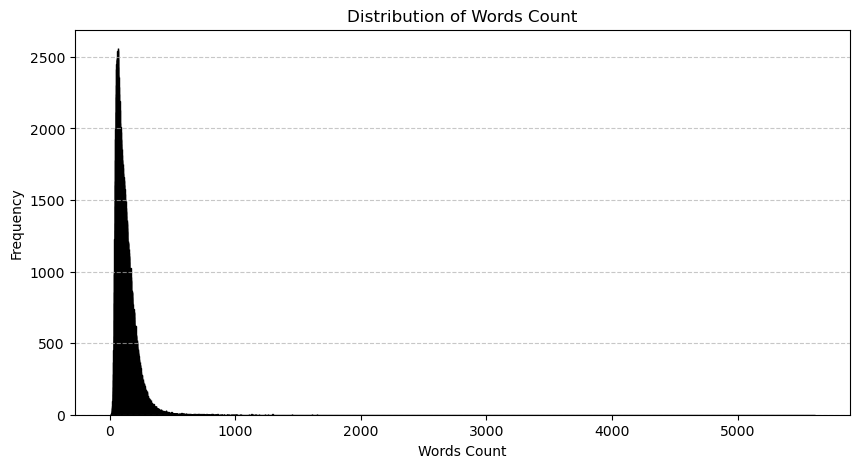

In [60]:
# Plot 1: Distribution of `words_count`
plt.figure(figsize=(10, 5))
plt.hist(df["words_count"], bins=range(df["words_count"].min(), df["words_count"].max() + 2), edgecolor='black', align='left')
plt.title("Distribution of Words Count")
plt.xlabel("Words Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Plot 2: Distribution of `chars_count`
plt.figure(figsize=(10, 5))
plt.hist(df["chars_count"], bins=range(df["chars_count"].min(), df["chars_count"].max() + 2, 5), edgecolor='black', align='left')
plt.title("Distribution of Characters Count")
plt.xlabel("Characters Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Printing outliers

In [35]:
def find_outliers_df(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter DataFrame for outliers
    outliers_df = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers_df

# Find outliers for `words_count`
words_outliers_df = find_outliers_df(df, "words_count")

# Find outliers for `chars_count`
chars_outliers_df = find_outliers_df(df, "chars_count")

# Combine both to see all outliers in a single DataFrame
extreme_values_df = pd.concat([words_outliers_df, chars_outliers_df]).drop_duplicates()

In [36]:
extreme_values_df.sort_values(by="chars_count", ascending=False).head()

,url,text,header,words_count,chars_count
721720,https://www.interpressnews.ge/ka/api/article/2...,ივლისის თვეში ჟურნალ ”გზის” სარეკლამო გაყიდვებ...,ივლისის თვეში ჟურნალ ”გზის” სარეკლამო გაყიდვებ...,68,85071
122870,https://www.interpressnews.ge/ka/api/article/8...,"გიორგი კობერიძე - “ისმის კითხვა, წარმოადგენს კ...",ქართული პრესის მიმოხილვა 27.05.2024,9230,80734
5440,https://www.interpressnews.ge/ka/api/article/7...,"თენგიზ ფხალაძე - “დასავლეთი ცდილობს, არ დაგვაშ...",ქართული პრესის მიმოხილვა 06.03.2023,8841,76818
324211,https://www.interpressnews.ge/ka/api/article/6...,სახელმწიფო ინსპექტორის აპარატმა საქართველოს მე...,სახელმწიფო ინსპექტორმა მიხეილ სააკაშვილის პერს...,2075,75089
512060,https://www.interpressnews.ge/ka/api/article/2...,"„ძლიერი, დემოკრატიული, ერთიანი საქართველოსთვის...",სამთავრობო პროგრამა,7306,74360


In [37]:
extreme_values_df.sort_values(by="words_count", ascending=False).head()

,url,text,header,words_count,chars_count
122870,https://www.interpressnews.ge/ka/api/article/8...,"გიორგი კობერიძე - “ისმის კითხვა, წარმოადგენს კ...",ქართული პრესის მიმოხილვა 27.05.2024,9230,80734
5440,https://www.interpressnews.ge/ka/api/article/7...,"თენგიზ ფხალაძე - “დასავლეთი ცდილობს, არ დაგვაშ...",ქართული პრესის მიმოხილვა 06.03.2023,8841,76818
388278,https://www.interpressnews.ge/ka/api/article/7...,ვახტანგ ძაბირაძე - “ზურაბიშვილმა უნდა დატოვოს ...,ქართული პრესის მიმოხილვა 04.12.2023,8094,72105
553511,https://www.interpressnews.ge/ka/api/article/8...,სანდრო თვალჭრელიძე - “კოალიციური მთავრობა არის...,ქართული პრესის მიმოხილვა 02.09.2024,8003,70748
623068,https://www.interpressnews.ge/ka/api/article/7...,პრეზიდენტის მთავარი გზავნილები ევროპარლამენტში...,ქართული პრესის მიმოხილვა 01.06.2023,7336,67312


In [38]:
extreme_values_df.sort_values(by="chars_count").head()

,url,text,header,words_count,chars_count
450822,https://www.interpressnews.ge/ka/api/article/2...,The Chairperson of the Central Election Commis...,Election administration is fully ready to con...,374,2510
81575,https://www.interpressnews.ge/ka/api/article/7...,"პესიმიზმი სუფევს საზოგადოებაში, მინდობილები ვა...","სალომე ზურაბიშვილი - პესიმიზმი სუფევს, მინდობი...",374,2685
453969,https://www.interpressnews.ge/ka/api/article/6...,გიორგი შაქარაშვილის საქმეზე მოწმის სახით გამოკ...,შაქარაშვილის საქმეზე გამოკითხული 3 პირის ადვოკ...,375,2722
417496,https://www.interpressnews.ge/ka/api/article/6...,"საქართველოს კალათბურთის ნაკრების კაპიტანი, თორ...","თორნიკე შენგელია - ვიყავი, ვარ და ვიქნები ქართ...",374,2726
12473,https://www.interpressnews.ge/ka/api/article/7...,"ვიღაცა, რომ არის ევროპარლამენტარი, ჩვენზე ძალი...","მეუფე იაკობი - ვიღაცა, რომ არის ევროპარლამენტა...",373,2726


In [39]:
extreme_values_df.sort_values(by="words_count").head()

,url,text,header,words_count,chars_count
721720,https://www.interpressnews.ge/ka/api/article/2...,ივლისის თვეში ჟურნალ ”გზის” სარეკლამო გაყიდვებ...,ივლისის თვეში ჟურნალ ”გზის” სარეკლამო გაყიდვებ...,68,85071
607215,https://www.interpressnews.ge/ka/api/article/6...,"პირი, რომელიც გიორგი შაქარაშვილის გაუჩინარების...","პირი, რომელიც გური ამირხანაშვილთან შესახვედრად...",91,74218
636217,https://www.interpressnews.ge/ka/api/article/6...,უკრაინის მთავრობა ქვეყნიდან მშვიდობიანი მოქალა...,უკრაინის მთავრობა ქვეყნიდან მშვიდობიანი მოქალა...,92,4094
264009,https://www.interpressnews.ge/ka/api/article/6...,უკრაინის მთავრობა ქვეყნიდან მშვიდობიანი მოქალა...,უკრაინის მთავრობა ქვეყნიდან მშვიდობიანი მოქალა...,102,9035
55702,https://www.interpressnews.ge/ka/api/article/5...,"ორი მუშის მდგომარეობა, რომლებიც მაშველებმა ზუგ...","ორი მუშის მდგომარეობა, რომლებიც ზუგდიდში სამუშ...",115,17174


# Words Length Distributions

In [40]:
# Tokenize words and calculate word lengths
all_words = [word for sentence in (df["header"] + ' ' + df['text']) for word in sentence.split()]
word_lengths = [len(word) for word in all_words]

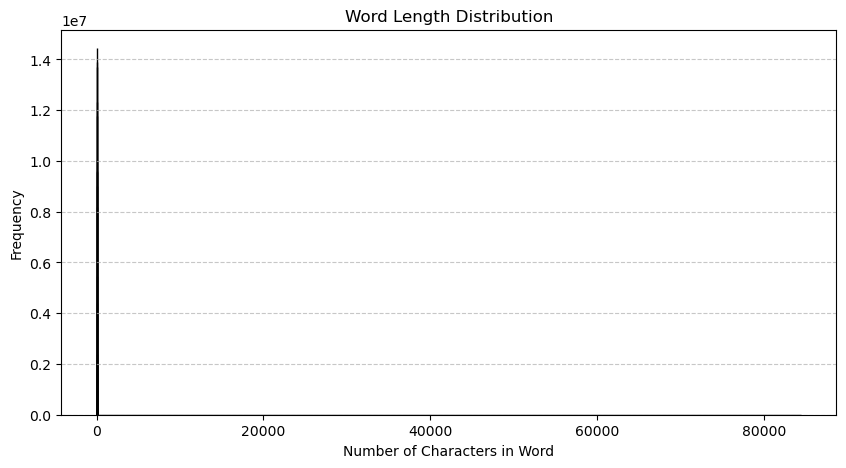

In [41]:
# Plot Word Length Distribution
plt.figure(figsize=(10, 5))
plt.hist(word_lengths, bins=range(1, max(word_lengths) + 1), edgecolor='black', align='left')
plt.title("Word Length Distribution")
plt.xlabel("Number of Characters in Word")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Top 10 longest words with their lengths:
![InterPressNews.Ge](: 84464
: 73392
ვიდეო:**](/ka/admin_palitra/articles/article/558732/change/S.K.1.08.19%20%20%E1%83%A1%E1%83%90%E1%83%9B%E1%83%90%E1%83%A0%E1%83%97%E1%83%90%E1%83%9A%E1%83%98%20%E1%83%90%E1%83%9C%E1%83%90%20%E1%83%93%E1%83%9D%E1%83%9A%E1%83%98%E1%83%AB%E1%83%94%20-%20%E1%83%92%E1%83%98%E1%83%9D%E1%83%A0%E1%83%92%E1%83%98%20%E1%83%9B%E1%83%98%E1%83%A5%E1%83%90%E1%83%A3%E1%83%A2%E1%83%90%E1%83%AB%E1%83%98%E1%83%A1%E1%83%90%20%E1%83%93%E1%83%90%20%E1%83%9C%E1%83%98%E1%83%9C%E1%83%9D%20%E1%83%A1%E1%83%90%E1%83%9C%E1%83%93%E1%83%9D%E1%83%AB%E1%83%98%E1%83%A1%20%E1%83%9B%E1%83%98%E1%83%9B%E1%83%90%E1%83%A0%E1%83%97%20%E1%83%90%E1%83%A0%E1%83%A1%E1%83%94%E1%83%91%E1%83%9D%E1%83%91%E1%83%A1%20%E1%83%99%E1%83%98%E1%83%97%E1%83%AE%E1%83%95%E1%83%94%E1%83%91%E1%83%98,%20%E1%83%A0%E1%83%9D%E1%83%92%E1%83%9D%E1%83%A0%E1%83%AA%20%E1%83%99%E1%83%9D%E1%83%9B%E1%83%9E%E1%83%94%E1%83%A2%E1%83%94%E1%83%9C%E1%83%AA%E1%83%98%E1%83%98%E1%83%A1,%20
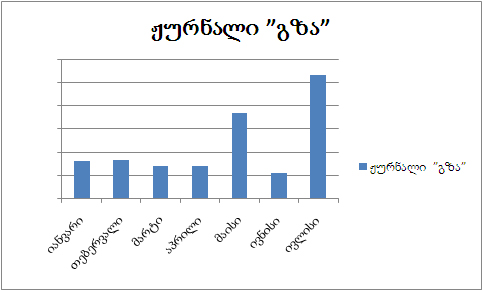
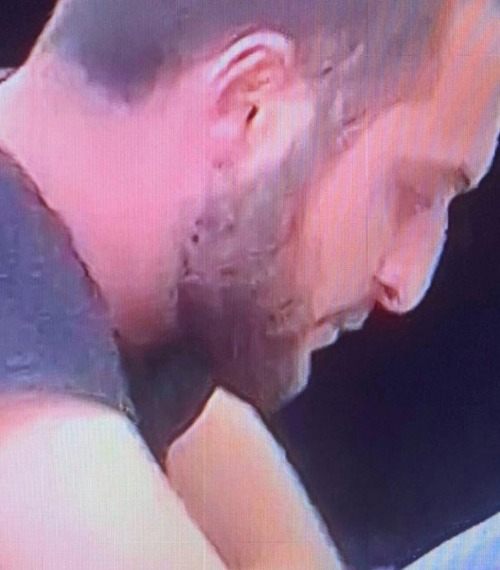

In [42]:
# Combine words with their lengths
word_length_pairs = list(zip(all_words, word_lengths))


# Sort by word length in descending order
sorted_word_length_pairs = sorted(word_length_pairs, key=lambda x: x[1], reverse=True)

# Print top highest words with their lengths
top_n = 10  # Number of top longest words to display
print(f"Top {top_n} longest words with their lengths:")
for word, length in sorted_word_length_pairs[:top_n]:
    print(f"{word}: {length}")

# Wordclouds

In [43]:
from nltk import ngrams

def ngram_analysis(txt, n=2, top_k=100):
    all_ngrams = [ngram for ngram in ngrams(tqdm(txt.split(), position=0, leave=True), n)]
    ngram_freq = Counter(all_ngrams).most_common(top_k)
    return ngram_freq

In [44]:
# Combine header and text into a single text
text = " ".join(df["header"] + ' ' + df["text"])

# Convert bigram counts to a dictionary
bigram_counts_dict = ngram_analysis(text, 2, top_k=200)

# Convert trigram counts to a dictionary
trigram_counts_dict = ngram_analysis(text, 3, top_k=200)

100%|██████████| 131276744/131276744 [00:32<00:00, 4093067.87it/s]


In [45]:
bigram_wordcloud_dict = {" ".join(k): v for k, v in bigram_counts_dict}
trigram_wordcloud_dict = {" ".join(k): v for k, v in trigram_counts_dict}

In [46]:
del text
import gc

print(f"{gc.collect()} objects collected. {len(gc.get_objects())} total objects in memory.")
print("")

4986633 objects collected. 230897 total objects in memory.



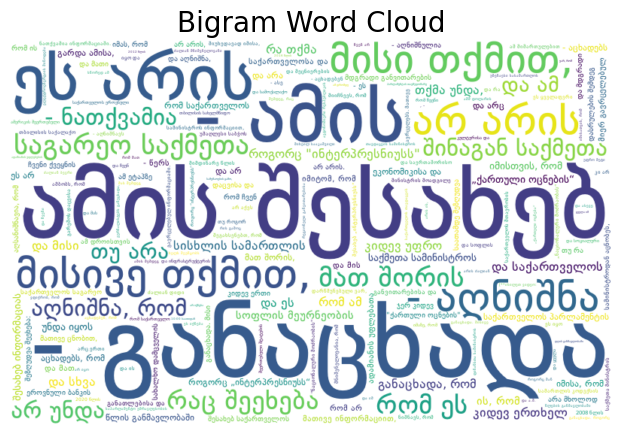

In [47]:
# Generate the word cloud
bigram_wordcloud = WordCloud(
    background_color='white',
    width=800,  # Reduce width
    height=512,  # Reduce height
    font_path='./bpg_dejavu_sans.otf'
).generate_from_frequencies(bigram_wordcloud_dict)


# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(bigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Bigram Word Cloud", fontsize=20)
plt.show()

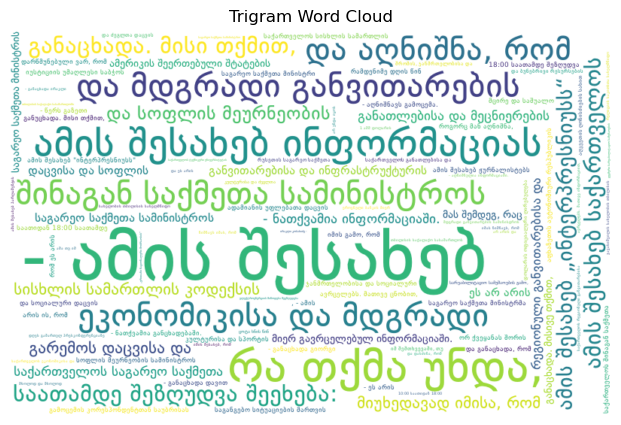

In [48]:
# Generate the word cloud
trigram_wordcloud = WordCloud(
    background_color='white',
    width=800,  # Reduce width
    height=512,  # Reduce height
    font_path='./bpg_dejavu_sans.otf'
).generate_from_frequencies(trigram_wordcloud_dict)

plt.figure(figsize=(10, 5))
plt.imshow(trigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Trigram Word Cloud")
plt.show()